# Test new model

In [1]:
import torch
from utils import get_bpr_data, get_bpr_train_loader

## Data

In [2]:
num_users, num_items, users_train, items_train, train_candidates, test_candidates = get_bpr_data()

In [3]:
train_loader = get_bpr_train_loader(users_train, items_train, train_candidates, num_items, shuffle=True)

In [4]:
len(train_loader)

98

## Model Config

In [5]:
from gcn.attention import DeePeamfii
from gcn.loss import BPRLoss
device = "cuda" if torch.cuda.is_available() else "cpu"
n_factors = 10
model = DeePeamfii(num_users, num_items, n_factors)
model.to(device)
learning_rate, weight_decay = 0.01, 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
loss_fn = BPRLoss()
print(f"device: {device}, n_factors: {n_factors}, learning_rate: {learning_rate}, weight_decay: {weight_decay}")

device: cuda, n_factors: 10, learning_rate: 0.01, weight_decay: 1e-05


## Train

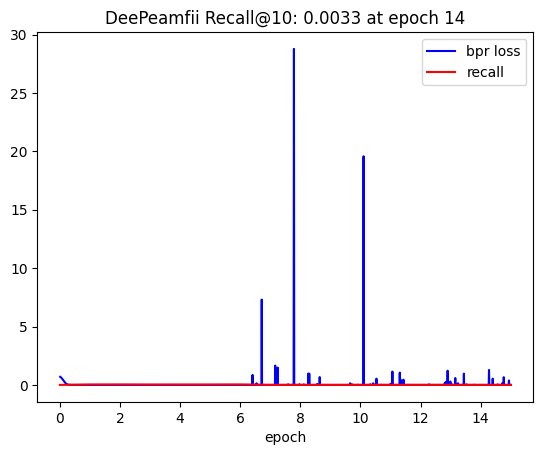

DeePeamfii Recall@10: 0.0033 at epoch 14
step:1/98 epoch:15/20 loss:2.284084530401742e-07
step:2/98 epoch:15/20 loss:3.6036738038092153e-06
step:3/98 epoch:15/20 loss:1.6020357263002438e-09
step:4/98 epoch:15/20 loss:6.309247169156151e-08
step:5/98 epoch:15/20 loss:6.180729261728857e-09
step:6/98 epoch:15/20 loss:5.635527031699894e-07
step:7/98 epoch:15/20 loss:2.853037361916222e-09
step:8/98 epoch:15/20 loss:2.2338748749461956e-05
step:9/98 epoch:15/20 loss:1.4588586054742336e-05
step:10/98 epoch:15/20 loss:3.7208791603404734e-10
step:11/98 epoch:15/20 loss:6.216902193045826e-07
step:12/98 epoch:15/20 loss:1.3291477785060124e-07
step:13/98 epoch:15/20 loss:3.476932164403479e-08
step:14/98 epoch:15/20 loss:2.759422557119251e-07
step:15/98 epoch:15/20 loss:2.734102055867993e-09
step:16/98 epoch:15/20 loss:5.8290602567012684e-08
step:17/98 epoch:15/20 loss:7.161846582448561e-08
step:18/98 epoch:15/20 loss:3.317067509556182e-09
step:19/98 epoch:15/20 loss:0.010565334931015968
step:20/98 e

In [6]:
from gcn.train import evaluate_ranking
from gcn.visualize import Animator
ani = Animator()
num_epochs = 20
topk = 10
train_epoch_perc = []
train_loss = []
epoch_list = []
recall_list = []

with torch.no_grad():
    recall = evaluate_ranking(
        model,
        test_candidates,
        train_candidates,
        num_users,
        num_items,
        top_k = topk
    )
    recall_list.append(recall)
    epoch_list.append(0)

for epoch in range(num_epochs):
    for batch, values in enumerate(train_loader):
        input_data = []
        for v in values:
            input_data.append(v.to(device))

        p_pos = model(input_data[0], input_data[1])
        p_neg = model(input_data[0], input_data[-1])
        loss = loss_fn(p_pos, p_neg)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 64 == 0:
        train_epoch_perc.append((batch+1)/ len(train_loader) + epoch)
        train_loss.append(loss.item())
        print(f'step:{batch+1}/{len(train_loader)} epoch:{epoch}/{num_epochs} loss:{train_loss[-1]}')


    with torch.no_grad():
        recall = evaluate_ranking(
            model,
            test_candidates,
            train_candidates,
            num_users,
            num_items,
            top_k = topk
        )
        recall_list.append(recall)
        epoch_list.append(epoch+1)


    scheduler.step()

    ani.clear()
    ani.ax.plot(train_epoch_perc, train_loss, color='b', label='bpr loss')
    ani.ax.plot(epoch_list, recall_list, color='r', label='recall')
    ani.ax.set_xlabel('epoch')
    ani.ax.legend()
    ani.ax.set_title(f'DeePeamfii Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')
    ani.render()

    print(f'DeePeamfii Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')

ani.close()

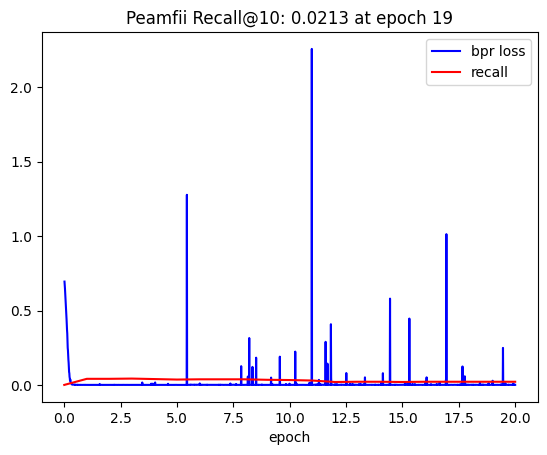

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_epoch_perc, train_loss, color='b', label='bpr loss')
plt.plot(epoch_list, recall_list, color='r', label='recall')
plt.xlabel("epoch")
plt.legend()
plt.title(f'DeePeamfii Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}')
plt.savefig(f'./images/DeePeamfii Recall@{topk}: {recall_list[-1]:.4f} at epoch {epoch}.png')
plt.show()

In [ ]:
recall_list

[0.0,
 0.040983606557377046,
 0.040983606557377046,
 0.04262295081967213,
 0.03934426229508197,
 0.036065573770491806,
 0.03770491803278689,
 0.03770491803278689,
 0.03770491803278689,
 0.03442622950819672,
 0.03278688524590164,
 0.029508196721311476,
 0.019672131147540985,
 0.021311475409836064,
 0.021311475409836064,
 0.019672131147540985,
 0.021311475409836064,
 0.021311475409836064,
 0.021311475409836064,
 0.021311475409836064,
 0.021311475409836064]

In [ ]:
# max(recall_list), min(rmse_list) 
print(f'DeePeamfii Max Recall@{topk}: {max(recall_list):.4f} at epoch {recall_list.index(max(recall_list))}')

Peamfii Max Recall@10: 0.0426 at epoch 3
